In [22]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [23]:
np.random.seed(0)

In [59]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
errors = np.sqrt(np.abs(np.diagonal(syscov)))

### Generate a data set with covariance matrix from the original plus gaussian noise

In [25]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

In [34]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))


(1000, 31, 31)


In [27]:
from astroNN.nn.layers import MCDropout

In [35]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.1)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_11 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_12 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_13 (MCDropout)     (None, 31)              

In [36]:
autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=1800,                                    
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/1800
25/25 [==============================] - 0s 8ms/step - loss: 2.9936e-06 - val_loss: 1.7514e-06
Epoch 2/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.5960e-06 - val_loss: 1.5138e-06
Epoch 3/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4677e-06 - val_loss: 1.4790e-06
Epoch 4/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4523e-06 - val_loss: 1.4643e-06
Epoch 5/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4589e-06 - val_loss: 1.5385e-06
Epoch 6/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4244e-06 - val_loss: 1.4498e-06
Epoch 7/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4287e-06 - val_loss: 1.4548e-06
Epoch 8/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.4053e-06 - val_loss: 1.4162e-06
Epoch 9/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.4149e-06 - val_loss: 1.4294e-06
Epoch 10/1800
25/25 [=======

25/25 [==============================] - 0s 3ms/step - loss: 1.1141e-06 - val_loss: 1.1383e-06
Epoch 77/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1139e-06 - val_loss: 1.1384e-06
Epoch 78/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1105e-06 - val_loss: 1.1314e-06
Epoch 79/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1114e-06 - val_loss: 1.1319e-06
Epoch 80/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1060e-06 - val_loss: 1.1274e-06
Epoch 81/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1151e-06 - val_loss: 1.1356e-06
Epoch 82/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1141e-06 - val_loss: 1.1289e-06
Epoch 83/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1088e-06 - val_loss: 1.1232e-06
Epoch 84/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.1065e-06 - val_loss: 1.1243e-06
Epoch 85/1800
25/25 [============

Epoch 151/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0805e-06 - val_loss: 1.0989e-06
Epoch 152/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0798e-06 - val_loss: 1.0941e-06
Epoch 153/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0829e-06 - val_loss: 1.1045e-06
Epoch 154/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0831e-06 - val_loss: 1.0964e-06
Epoch 155/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0838e-06 - val_loss: 1.0970e-06
Epoch 156/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0812e-06 - val_loss: 1.1024e-06
Epoch 157/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0816e-06 - val_loss: 1.0974e-06
Epoch 158/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0786e-06 - val_loss: 1.0952e-06
Epoch 159/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0825e-06 - val_loss: 1.1060e-06
Epoch 160/

25/25 [==============================] - 0s 4ms/step - loss: 1.0720e-06 - val_loss: 1.0862e-06
Epoch 226/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0733e-06 - val_loss: 1.0863e-06
Epoch 227/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0745e-06 - val_loss: 1.0887e-06
Epoch 228/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0751e-06 - val_loss: 1.0894e-06
Epoch 229/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0754e-06 - val_loss: 1.0836e-06
Epoch 230/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0725e-06 - val_loss: 1.0862e-06
Epoch 231/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0710e-06 - val_loss: 1.0951e-06
Epoch 232/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0746e-06 - val_loss: 1.0862e-06
Epoch 233/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0723e-06 - val_loss: 1.0855e-06
Epoch 234/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0661e-06 - val_loss: 1.0818e-06
Epoch 300/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0675e-06 - val_loss: 1.0804e-06
Epoch 301/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0681e-06 - val_loss: 1.0890e-06
Epoch 302/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0696e-06 - val_loss: 1.0787e-06
Epoch 303/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0642e-06 - val_loss: 1.0802e-06
Epoch 304/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0697e-06 - val_loss: 1.0892e-06
Epoch 305/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0686e-06 - val_loss: 1.0798e-06
Epoch 306/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0687e-06 - val_loss: 1.0816e-06
Epoch 307/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0681e-06 - val_loss: 1.0802e-06
Epoch 308/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0660e-06 - val_loss: 1.0873e-06
Epoch 374/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0682e-06 - val_loss: 1.0777e-06
Epoch 375/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0644e-06 - val_loss: 1.0768e-06
Epoch 376/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0626e-06 - val_loss: 1.0800e-06
Epoch 377/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0654e-06 - val_loss: 1.0782e-06
Epoch 378/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0631e-06 - val_loss: 1.0765e-06
Epoch 379/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0666e-06 - val_loss: 1.0851e-06
Epoch 380/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0662e-06 - val_loss: 1.0783e-06
Epoch 381/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0664e-06 - val_loss: 1.0802e-06
Epoch 382/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0645e-06 - val_loss: 1.0783e-06
Epoch 448/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0628e-06 - val_loss: 1.0756e-06
Epoch 449/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0602e-06 - val_loss: 1.0797e-06
Epoch 450/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0627e-06 - val_loss: 1.0730e-06
Epoch 451/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0627e-06 - val_loss: 1.0750e-06
Epoch 452/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0624e-06 - val_loss: 1.0738e-06
Epoch 453/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0630e-06 - val_loss: 1.0783e-06
Epoch 454/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0630e-06 - val_loss: 1.0765e-06
Epoch 455/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0609e-06 - val_loss: 1.0705e-06
Epoch 456/1800
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0575e-06 - val_loss: 1.0715e-06
Epoch 522/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0594e-06 - val_loss: 1.0706e-06
Epoch 523/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0587e-06 - val_loss: 1.0740e-06
Epoch 524/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0623e-06 - val_loss: 1.0745e-06
Epoch 525/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0627e-06 - val_loss: 1.0749e-06
Epoch 526/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0592e-06 - val_loss: 1.0761e-06
Epoch 527/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0588e-06 - val_loss: 1.0663e-06
Epoch 528/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0595e-06 - val_loss: 1.0754e-06
Epoch 529/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0606e-06 - val_loss: 1.0744e-06
Epoch 530/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0700e-06
Epoch 596/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0577e-06 - val_loss: 1.0745e-06
Epoch 597/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0556e-06 - val_loss: 1.0638e-06
Epoch 598/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0567e-06 - val_loss: 1.0737e-06
Epoch 599/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0615e-06 - val_loss: 1.0742e-06
Epoch 600/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0584e-06 - val_loss: 1.0695e-06
Epoch 601/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0585e-06 - val_loss: 1.0766e-06
Epoch 602/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0568e-06 - val_loss: 1.0665e-06
Epoch 603/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0614e-06 - val_loss: 1.0754e-06
Epoch 604/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0568e-06 - val_loss: 1.0735e-06
Epoch 670/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0581e-06 - val_loss: 1.0693e-06
Epoch 671/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0574e-06 - val_loss: 1.0717e-06
Epoch 672/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0597e-06 - val_loss: 1.0680e-06
Epoch 673/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0590e-06 - val_loss: 1.0695e-06
Epoch 674/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0583e-06 - val_loss: 1.0804e-06
Epoch 675/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0617e-06 - val_loss: 1.0723e-06
Epoch 676/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0580e-06 - val_loss: 1.0726e-06
Epoch 677/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0573e-06 - val_loss: 1.0721e-06
Epoch 678/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0554e-06 - val_loss: 1.0684e-06
Epoch 744/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0584e-06 - val_loss: 1.0708e-06
Epoch 745/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0599e-06 - val_loss: 1.0721e-06
Epoch 746/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0608e-06 - val_loss: 1.0724e-06
Epoch 747/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0573e-06 - val_loss: 1.0693e-06
Epoch 748/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0556e-06 - val_loss: 1.0738e-06
Epoch 749/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0568e-06 - val_loss: 1.0683e-06
Epoch 750/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0547e-06 - val_loss: 1.0644e-06
Epoch 751/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0540e-06 - val_loss: 1.0705e-06
Epoch 752/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0572e-06 - val_loss: 1.0651e-06
Epoch 818/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0569e-06 - val_loss: 1.0678e-06
Epoch 819/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0571e-06 - val_loss: 1.0703e-06
Epoch 820/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0562e-06 - val_loss: 1.0690e-06
Epoch 821/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0521e-06 - val_loss: 1.0644e-06
Epoch 822/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0548e-06 - val_loss: 1.0724e-06
Epoch 823/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0592e-06 - val_loss: 1.0632e-06
Epoch 824/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0549e-06 - val_loss: 1.0719e-06
Epoch 825/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0552e-06 - val_loss: 1.0679e-06
Epoch 826/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0565e-06 - val_loss: 1.0745e-06
Epoch 892/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0527e-06 - val_loss: 1.0669e-06
Epoch 893/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0529e-06 - val_loss: 1.0684e-06
Epoch 894/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0725e-06
Epoch 895/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0568e-06 - val_loss: 1.0668e-06
Epoch 896/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0582e-06 - val_loss: 1.0711e-06
Epoch 897/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0586e-06 - val_loss: 1.0716e-06
Epoch 898/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0562e-06 - val_loss: 1.0709e-06
Epoch 899/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0539e-06 - val_loss: 1.0714e-06
Epoch 900/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0535e-06 - val_loss: 1.0694e-06
Epoch 966/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0565e-06 - val_loss: 1.0715e-06
Epoch 967/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0524e-06 - val_loss: 1.0711e-06
Epoch 968/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0550e-06 - val_loss: 1.0618e-06
Epoch 969/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0527e-06 - val_loss: 1.0670e-06
Epoch 970/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0484e-06 - val_loss: 1.0612e-06
Epoch 971/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0504e-06 - val_loss: 1.0639e-06
Epoch 972/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0519e-06 - val_loss: 1.0704e-06
Epoch 973/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0526e-06 - val_loss: 1.0671e-06
Epoch 974/1800
25/25 [===

25/25 [==============================] - 0s 4ms/step - loss: 1.0493e-06 - val_loss: 1.0589e-06
Epoch 1040/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0497e-06 - val_loss: 1.0674e-06
Epoch 1041/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0511e-06 - val_loss: 1.0671e-06
Epoch 1042/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0551e-06 - val_loss: 1.0730e-06
Epoch 1043/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0522e-06 - val_loss: 1.0646e-06
Epoch 1044/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0518e-06 - val_loss: 1.0737e-06
Epoch 1045/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0553e-06 - val_loss: 1.0700e-06
Epoch 1046/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0542e-06 - val_loss: 1.0706e-06
Epoch 1047/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0536e-06 - val_loss: 1.0730e-06
Epoch 1048/1800
2

Epoch 1113/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0530e-06 - val_loss: 1.0680e-06
Epoch 1114/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0533e-06 - val_loss: 1.0664e-06
Epoch 1115/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0529e-06 - val_loss: 1.0667e-06
Epoch 1116/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0518e-06 - val_loss: 1.0727e-06
Epoch 1117/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0532e-06 - val_loss: 1.0674e-06
Epoch 1118/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0515e-06 - val_loss: 1.0691e-06
Epoch 1119/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0554e-06 - val_loss: 1.0747e-06
Epoch 1120/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0564e-06 - val_loss: 1.0758e-06
Epoch 1121/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0533e-06 - val_loss: 1.0676e-06
E

Epoch 1187/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0502e-06 - val_loss: 1.0706e-06
Epoch 1188/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0492e-06 - val_loss: 1.0653e-06
Epoch 1189/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0487e-06 - val_loss: 1.0633e-06
Epoch 1190/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0523e-06 - val_loss: 1.0605e-06
Epoch 1191/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0489e-06 - val_loss: 1.0659e-06
Epoch 1192/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0505e-06 - val_loss: 1.0664e-06
Epoch 1193/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0527e-06 - val_loss: 1.0713e-06
Epoch 1194/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0518e-06 - val_loss: 1.0653e-06
Epoch 1195/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0530e-06 - val_loss: 1.0700e-06
E

Epoch 1261/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0499e-06 - val_loss: 1.0666e-06
Epoch 1262/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0471e-06 - val_loss: 1.0664e-06
Epoch 1263/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0518e-06 - val_loss: 1.0745e-06
Epoch 1264/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0503e-06 - val_loss: 1.0669e-06
Epoch 1265/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0506e-06 - val_loss: 1.0686e-06
Epoch 1266/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0511e-06 - val_loss: 1.0685e-06
Epoch 1267/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0494e-06 - val_loss: 1.0625e-06
Epoch 1268/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0473e-06 - val_loss: 1.0645e-06
Epoch 1269/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0490e-06 - val_loss: 1.0697e-06
E

Epoch 1335/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0513e-06 - val_loss: 1.0659e-06
Epoch 1336/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0510e-06 - val_loss: 1.0661e-06
Epoch 1337/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0504e-06 - val_loss: 1.0755e-06
Epoch 1338/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0544e-06 - val_loss: 1.0645e-06
Epoch 1339/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0476e-06 - val_loss: 1.0664e-06
Epoch 1340/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0493e-06 - val_loss: 1.0720e-06
Epoch 1341/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0515e-06 - val_loss: 1.0635e-06
Epoch 1342/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0485e-06 - val_loss: 1.0610e-06
Epoch 1343/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0477e-06 - val_loss: 1.0669e-06
E

Epoch 1409/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0472e-06 - val_loss: 1.0659e-06
Epoch 1410/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0474e-06 - val_loss: 1.0667e-06
Epoch 1411/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0505e-06 - val_loss: 1.0706e-06
Epoch 1412/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0464e-06 - val_loss: 1.0572e-06
Epoch 1413/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0497e-06 - val_loss: 1.0687e-06
Epoch 1414/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0492e-06 - val_loss: 1.0693e-06
Epoch 1415/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0492e-06 - val_loss: 1.0685e-06
Epoch 1416/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0484e-06 - val_loss: 1.0645e-06
Epoch 1417/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0503e-06 - val_loss: 1.0604e-06
E

Epoch 1483/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0449e-06 - val_loss: 1.0648e-06
Epoch 1484/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0448e-06 - val_loss: 1.0659e-06
Epoch 1485/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0471e-06 - val_loss: 1.0626e-06
Epoch 1486/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0465e-06 - val_loss: 1.0636e-06
Epoch 1487/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0495e-06 - val_loss: 1.0674e-06
Epoch 1488/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0490e-06 - val_loss: 1.0703e-06
Epoch 1489/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0493e-06 - val_loss: 1.0730e-06
Epoch 1490/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0490e-06 - val_loss: 1.0666e-06
Epoch 1491/1800
25/25 [==============================] - 1s 45ms/step - loss: 1.0495e-06 - val_loss: 1.0689e-06


Epoch 1557/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0474e-06 - val_loss: 1.0640e-06
Epoch 1558/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0465e-06 - val_loss: 1.0561e-06
Epoch 1559/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0428e-06 - val_loss: 1.0592e-06
Epoch 1560/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0474e-06 - val_loss: 1.0686e-06
Epoch 1561/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0466e-06 - val_loss: 1.0717e-06
Epoch 1562/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0477e-06 - val_loss: 1.0670e-06
Epoch 1563/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0484e-06 - val_loss: 1.0724e-06
Epoch 1564/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0486e-06 - val_loss: 1.0715e-06
Epoch 1565/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0492e-06 - val_loss: 1.0706e-06
E

Epoch 1631/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0445e-06 - val_loss: 1.0690e-06
Epoch 1632/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0460e-06 - val_loss: 1.0596e-06
Epoch 1633/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0431e-06 - val_loss: 1.0604e-06
Epoch 1634/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0428e-06 - val_loss: 1.0648e-06
Epoch 1635/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0424e-06 - val_loss: 1.0605e-06
Epoch 1636/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0442e-06 - val_loss: 1.0697e-06
Epoch 1637/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0451e-06 - val_loss: 1.0628e-06
Epoch 1638/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0448e-06 - val_loss: 1.0588e-06
Epoch 1639/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0446e-06 - val_loss: 1.0716e-06
E

Epoch 1705/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0429e-06 - val_loss: 1.0636e-06
Epoch 1706/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0410e-06 - val_loss: 1.0660e-06
Epoch 1707/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0436e-06 - val_loss: 1.0676e-06
Epoch 1708/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0451e-06 - val_loss: 1.0662e-06
Epoch 1709/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0432e-06 - val_loss: 1.0694e-06
Epoch 1710/1800
25/25 [==============================] - 0s 3ms/step - loss: 1.0459e-06 - val_loss: 1.0662e-06
Epoch 1711/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0444e-06 - val_loss: 1.0667e-06
Epoch 1712/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0429e-06 - val_loss: 1.0613e-06
Epoch 1713/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0453e-06 - val_loss: 1.0686e-06
E

Epoch 1779/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0404e-06 - val_loss: 1.0671e-06
Epoch 1780/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0435e-06 - val_loss: 1.0635e-06
Epoch 1781/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0430e-06 - val_loss: 1.0624e-06
Epoch 1782/1800
25/25 [==============================] - 0s 5ms/step - loss: 1.0441e-06 - val_loss: 1.0652e-06
Epoch 1783/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0447e-06 - val_loss: 1.0601e-06
Epoch 1784/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0420e-06 - val_loss: 1.0643e-06
Epoch 1785/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0408e-06 - val_loss: 1.0625e-06
Epoch 1786/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0414e-06 - val_loss: 1.0675e-06
Epoch 1787/1800
25/25 [==============================] - 0s 4ms/step - loss: 1.0427e-06 - val_loss: 1.0656e-06
E

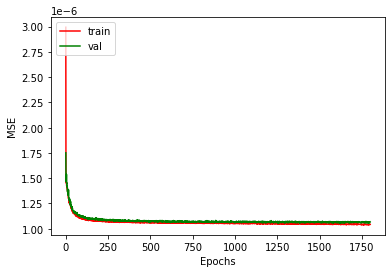

In [37]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [38]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [39]:
decoder2.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_14 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_15 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
_______________________________________________

In [40]:
encoded_imgs = encoder2.predict(covset_test)
decoded_imgs = decoder2.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)


(200, 31)


In [45]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

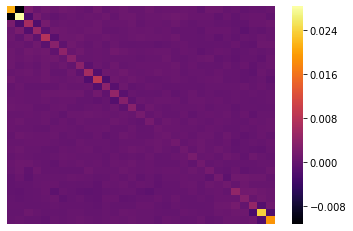

In [46]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# FFNN

In [47]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

z = data[:,0]
dl = data[:,1:]
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)



In [48]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.1)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.1)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                100       
_________________________________________________________________
MCDropout_16 (MCDropout)     (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_17 (MCDropout)     (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_18 (MCDropout)     (None, 50)              

In [49]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=2,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/800
12/12 [==============================] - 0s 12ms/step - loss: 1440.4414 - val_loss: 1739.1057
Epoch 2/800
12/12 [==============================] - 0s 3ms/step - loss: 1423.8677 - val_loss: 1724.0022
Epoch 3/800
12/12 [==============================] - 0s 3ms/step - loss: 1396.9874 - val_loss: 1691.5673
Epoch 4/800
12/12 [==============================] - 0s 2ms/step - loss: 1350.5667 - val_loss: 1600.8414
Epoch 5/800
12/12 [==============================] - 0s 3ms/step - loss: 1229.4238 - val_loss: 1490.9180
Epoch 6/800
12/12 [==============================] - 0s 3ms/step - loss: 999.7492 - val_loss: 1148.3342
Epoch 7/800
12/12 [==============================] - 0s 2ms/step - loss: 579.4033 - val_loss: 635.7041
Epoch 8/800
12/12 [==============================] - 0s 3ms/step - loss: 215.6740 - val_loss: 282.8421
Epoch 9/800
12/12 [==============================] - 0s 3ms/step - loss: 133.3148 - val_loss: 217.7243
Epoch 10/800
12/12 [==============================] - 0s 3ms/

Epoch 81/800
12/12 [==============================] - 0s 3ms/step - loss: 10.7701 - val_loss: 21.4311
Epoch 82/800
12/12 [==============================] - 0s 3ms/step - loss: 37.6042 - val_loss: 43.2878
Epoch 83/800
12/12 [==============================] - 0s 3ms/step - loss: 32.6370 - val_loss: 28.8768
Epoch 84/800
12/12 [==============================] - 0s 3ms/step - loss: 33.5279 - val_loss: 33.4945
Epoch 85/800
12/12 [==============================] - 0s 3ms/step - loss: 30.0100 - val_loss: 53.8034
Epoch 86/800
12/12 [==============================] - 0s 3ms/step - loss: 29.6625 - val_loss: 26.9057
Epoch 87/800
12/12 [==============================] - 0s 2ms/step - loss: 18.8670 - val_loss: 31.5518
Epoch 88/800
12/12 [==============================] - 0s 3ms/step - loss: 21.1565 - val_loss: 14.7577
Epoch 89/800
12/12 [==============================] - 0s 3ms/step - loss: 31.0713 - val_loss: 17.4419
Epoch 90/800
12/12 [==============================] - 0s 2ms/step - loss: 38.7346 

Epoch 161/800
12/12 [==============================] - 0s 3ms/step - loss: 39.3644 - val_loss: 27.3062
Epoch 162/800
12/12 [==============================] - 0s 3ms/step - loss: 30.7000 - val_loss: 17.1629
Epoch 163/800
12/12 [==============================] - 0s 3ms/step - loss: 22.6601 - val_loss: 26.0747
Epoch 164/800
12/12 [==============================] - 0s 3ms/step - loss: 22.0520 - val_loss: 46.5514
Epoch 165/800
12/12 [==============================] - 0s 3ms/step - loss: 32.7304 - val_loss: 53.6388
Epoch 166/800
12/12 [==============================] - 0s 3ms/step - loss: 29.8512 - val_loss: 25.4459
Epoch 167/800
12/12 [==============================] - 0s 3ms/step - loss: 16.1782 - val_loss: 18.9897
Epoch 168/800
12/12 [==============================] - 0s 3ms/step - loss: 11.2015 - val_loss: 39.4885
Epoch 169/800
12/12 [==============================] - 0s 3ms/step - loss: 16.0329 - val_loss: 64.8774
Epoch 170/800
12/12 [==============================] - 0s 3ms/step - loss

12/12 [==============================] - 0s 3ms/step - loss: 35.4983 - val_loss: 14.8319
Epoch 241/800
12/12 [==============================] - 0s 3ms/step - loss: 29.5975 - val_loss: 23.9940
Epoch 242/800
12/12 [==============================] - 0s 3ms/step - loss: 13.8743 - val_loss: 20.9103
Epoch 243/800
12/12 [==============================] - 0s 3ms/step - loss: 17.6958 - val_loss: 37.6318
Epoch 244/800
12/12 [==============================] - 0s 2ms/step - loss: 20.0278 - val_loss: 34.8847
Epoch 245/800
12/12 [==============================] - 0s 3ms/step - loss: 14.3226 - val_loss: 51.8067
Epoch 246/800
12/12 [==============================] - 0s 3ms/step - loss: 23.2465 - val_loss: 46.8668
Epoch 247/800
12/12 [==============================] - 0s 3ms/step - loss: 27.5032 - val_loss: 29.1171
Epoch 248/800
12/12 [==============================] - 0s 2ms/step - loss: 16.5789 - val_loss: 12.8923
Epoch 249/800
12/12 [==============================] - 0s 2ms/step - loss: 16.3579 - va

12/12 [==============================] - 0s 3ms/step - loss: 23.1212 - val_loss: 24.5624
Epoch 320/800
12/12 [==============================] - 0s 3ms/step - loss: 22.7801 - val_loss: 6.5256
Epoch 321/800
12/12 [==============================] - 0s 4ms/step - loss: 12.2690 - val_loss: 20.9418
Epoch 322/800
12/12 [==============================] - 0s 3ms/step - loss: 23.7694 - val_loss: 11.3714
Epoch 323/800
12/12 [==============================] - 0s 3ms/step - loss: 16.3106 - val_loss: 27.7318
Epoch 324/800
12/12 [==============================] - 0s 2ms/step - loss: 19.4539 - val_loss: 15.3422
Epoch 325/800
12/12 [==============================] - 0s 3ms/step - loss: 12.9877 - val_loss: 18.7347
Epoch 326/800
12/12 [==============================] - 0s 3ms/step - loss: 16.7044 - val_loss: 16.5636
Epoch 327/800
12/12 [==============================] - 0s 2ms/step - loss: 14.4561 - val_loss: 10.5665
Epoch 328/800
12/12 [==============================] - 0s 2ms/step - loss: 24.6608 - val

12/12 [==============================] - 0s 2ms/step - loss: 21.3062 - val_loss: 23.9888
Epoch 399/800
12/12 [==============================] - 0s 3ms/step - loss: 15.7326 - val_loss: 20.7430
Epoch 400/800
12/12 [==============================] - 0s 2ms/step - loss: 16.4779 - val_loss: 34.9449
Epoch 401/800
12/12 [==============================] - 0s 2ms/step - loss: 20.7005 - val_loss: 64.4876
Epoch 402/800
12/12 [==============================] - 0s 3ms/step - loss: 32.8040 - val_loss: 10.7110
Epoch 403/800
12/12 [==============================] - 0s 2ms/step - loss: 17.5665 - val_loss: 6.2701
Epoch 404/800
12/12 [==============================] - 0s 2ms/step - loss: 12.6900 - val_loss: 17.4288
Epoch 405/800
12/12 [==============================] - 0s 2ms/step - loss: 14.0105 - val_loss: 8.8285
Epoch 406/800
12/12 [==============================] - 0s 2ms/step - loss: 29.7762 - val_loss: 15.6561
Epoch 407/800
12/12 [==============================] - 0s 2ms/step - loss: 22.0642 - val_

Epoch 478/800
12/12 [==============================] - 0s 2ms/step - loss: 20.8587 - val_loss: 30.4112
Epoch 479/800
12/12 [==============================] - 0s 2ms/step - loss: 17.5252 - val_loss: 14.4221
Epoch 480/800
12/12 [==============================] - 0s 2ms/step - loss: 25.6680 - val_loss: 21.2730
Epoch 481/800
12/12 [==============================] - 0s 2ms/step - loss: 19.2301 - val_loss: 4.4855
Epoch 482/800
12/12 [==============================] - 0s 2ms/step - loss: 16.6339 - val_loss: 6.3138
Epoch 483/800
12/12 [==============================] - 0s 2ms/step - loss: 9.3017 - val_loss: 52.5676
Epoch 484/800
12/12 [==============================] - 0s 2ms/step - loss: 28.8092 - val_loss: 3.2992
Epoch 485/800
12/12 [==============================] - 0s 2ms/step - loss: 22.4151 - val_loss: 7.3606
Epoch 486/800
12/12 [==============================] - 0s 2ms/step - loss: 16.4835 - val_loss: 44.2081
Epoch 487/800
12/12 [==============================] - 0s 3ms/step - loss: 15.

12/12 [==============================] - 0s 3ms/step - loss: 13.3526 - val_loss: 22.6388
Epoch 558/800
12/12 [==============================] - 0s 3ms/step - loss: 23.1565 - val_loss: 50.2196
Epoch 559/800
12/12 [==============================] - 0s 2ms/step - loss: 15.2521 - val_loss: 20.9604
Epoch 560/800
12/12 [==============================] - 0s 2ms/step - loss: 14.1259 - val_loss: 30.6606
Epoch 561/800
12/12 [==============================] - 0s 3ms/step - loss: 20.7726 - val_loss: 25.8923
Epoch 562/800
12/12 [==============================] - 0s 3ms/step - loss: 18.4674 - val_loss: 19.5614
Epoch 563/800
12/12 [==============================] - 0s 3ms/step - loss: 14.2192 - val_loss: 33.6246
Epoch 564/800
12/12 [==============================] - 0s 2ms/step - loss: 21.7033 - val_loss: 21.2573
Epoch 565/800
12/12 [==============================] - 0s 2ms/step - loss: 18.7246 - val_loss: 11.8600
Epoch 566/800
12/12 [==============================] - 0s 2ms/step - loss: 8.9960 - val

Epoch 637/800
12/12 [==============================] - 0s 3ms/step - loss: 20.9099 - val_loss: 49.4001
Epoch 638/800
12/12 [==============================] - 0s 3ms/step - loss: 21.1215 - val_loss: 16.0790
Epoch 639/800
12/12 [==============================] - 0s 3ms/step - loss: 10.1299 - val_loss: 43.9566
Epoch 640/800
12/12 [==============================] - 0s 3ms/step - loss: 17.8842 - val_loss: 10.9521
Epoch 641/800
12/12 [==============================] - 0s 3ms/step - loss: 9.8936 - val_loss: 6.4085
Epoch 642/800
12/12 [==============================] - 0s 3ms/step - loss: 20.4934 - val_loss: 18.4882
Epoch 643/800
12/12 [==============================] - 0s 3ms/step - loss: 14.8363 - val_loss: 11.2611
Epoch 644/800
12/12 [==============================] - 0s 3ms/step - loss: 12.1446 - val_loss: 15.5882
Epoch 645/800
12/12 [==============================] - 0s 2ms/step - loss: 23.9844 - val_loss: 13.1631
Epoch 646/800
12/12 [==============================] - 0s 3ms/step - loss: 

Epoch 717/800
12/12 [==============================] - 0s 3ms/step - loss: 13.7922 - val_loss: 7.7471
Epoch 718/800
12/12 [==============================] - 0s 3ms/step - loss: 10.5608 - val_loss: 11.2871
Epoch 719/800
12/12 [==============================] - 0s 3ms/step - loss: 9.5250 - val_loss: 27.5285
Epoch 720/800
12/12 [==============================] - 0s 3ms/step - loss: 24.3712 - val_loss: 32.4166
Epoch 721/800
12/12 [==============================] - 0s 3ms/step - loss: 7.9072 - val_loss: 14.8684
Epoch 722/800
12/12 [==============================] - 0s 3ms/step - loss: 16.6941 - val_loss: 26.0119
Epoch 723/800
12/12 [==============================] - 0s 3ms/step - loss: 11.1147 - val_loss: 13.1511
Epoch 724/800
12/12 [==============================] - 0s 3ms/step - loss: 15.1917 - val_loss: 13.1981
Epoch 725/800
12/12 [==============================] - 0s 3ms/step - loss: 23.9585 - val_loss: 34.0547
Epoch 726/800
12/12 [==============================] - 0s 3ms/step - loss: 9

Epoch 797/800
12/12 [==============================] - 0s 3ms/step - loss: 24.0327 - val_loss: 7.2919
Epoch 798/800
12/12 [==============================] - 0s 3ms/step - loss: 10.3699 - val_loss: 24.3868
Epoch 799/800
12/12 [==============================] - 0s 3ms/step - loss: 15.1252 - val_loss: 15.8286
Epoch 800/800
12/12 [==============================] - 0s 4ms/step - loss: 11.7422 - val_loss: 15.7269


In [50]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



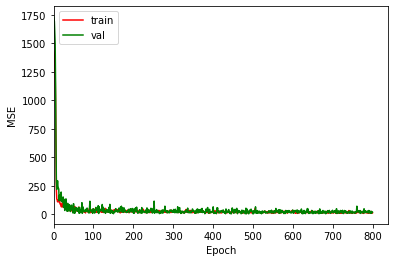

In [51]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [52]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model2.predict(ranzz)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$

In [60]:
fake_encoded = np.zeros((1, 31))
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]
decoded_fake = decoder2.predict(fake_encoded)
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))

(1, 31)
(31,)
(200, 31)
<class 'numpy.ndarray'>


In [61]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [62]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

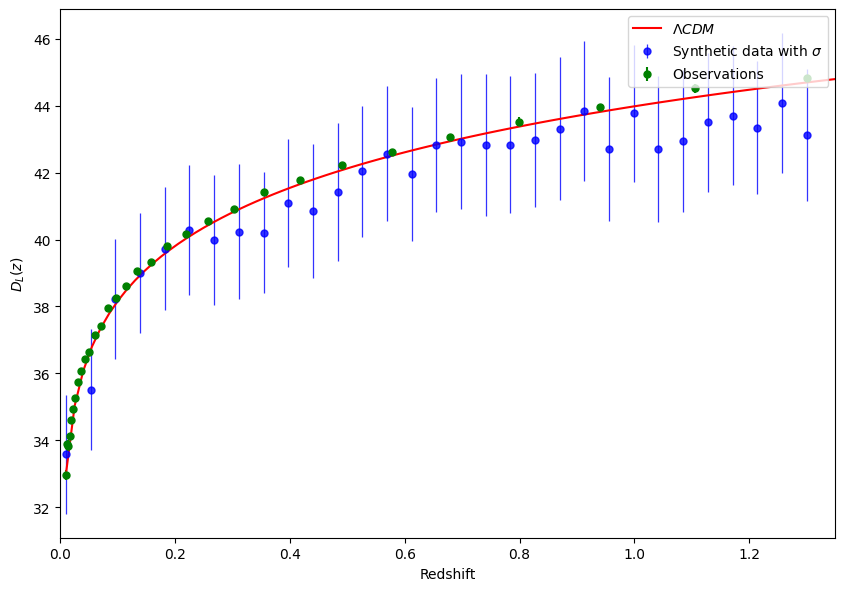

In [63]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [64]:
matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
np.fill_diagonal(matrix_with_all_err, sigma**2)

In [68]:
np.savetxt("fake_binned_JLA_COVdecodedDO2.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [ ]:
# autoencoder2.save('autoencoderJLA_DO.h5')
# decoder2.save('decoderJLA_DO.h5')
# neural_model2.save('FFNN_JLA_DO.h5')
# encoder2.save('encoderJLA_DO.h5')